In [1]:
# ====================================================================
# Proje Kurulumu: Gerekli Kütüphanelerin Yüklenmesi
# ====================================================================
!pip install -q torch torchvision torchaudio
!pip install -q opencv-python matplotlib pandas
!pip install -q filterpy
print("Tüm gerekli kütüphaneler kuruldu veya zaten mevcut.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Tüm gerekli kütüphaneler kuruldu veya zaten mevcut.


Kullanılacak Cihaz: cuda


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 208MB/s]



Görev 2: Nesne Tespiti Modeli Eğitimi Başlatılıyor...
Epoch 1/5, Ortalama Kayıp: 0.2525
Epoch 2/5, Ortalama Kayıp: 0.1763
Epoch 3/5, Ortalama Kayıp: 0.1499
Epoch 4/5, Ortalama Kayıp: 0.1304
Epoch 5/5, Ortalama Kayıp: 0.1166

Eğitim Tamamlandı! Model '/kaggle/working/models/pascal_object_detector.pth' olarak kaydedildi.

--- Test Sonucu: city_traffic.jpg ---


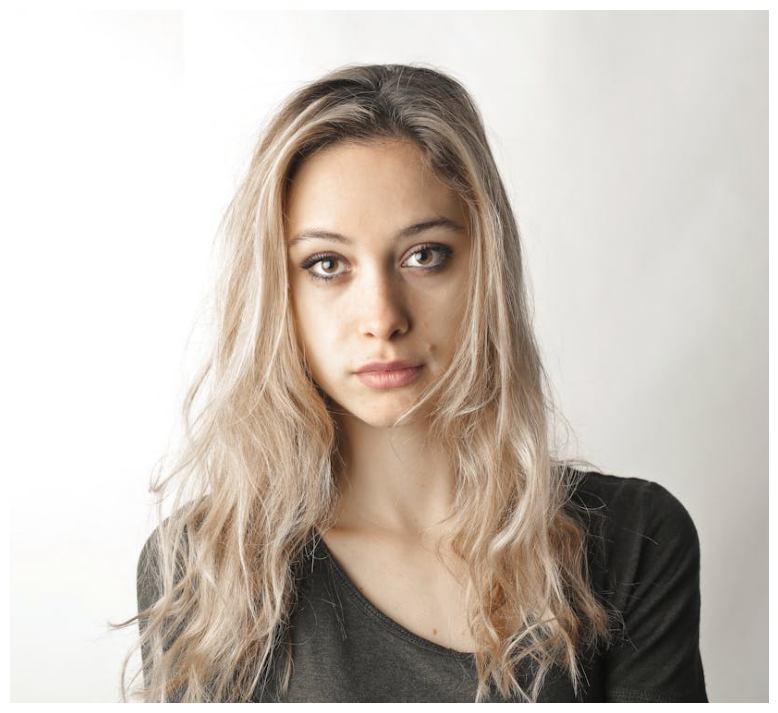


--- Test Sonucu: airport.jpg ---


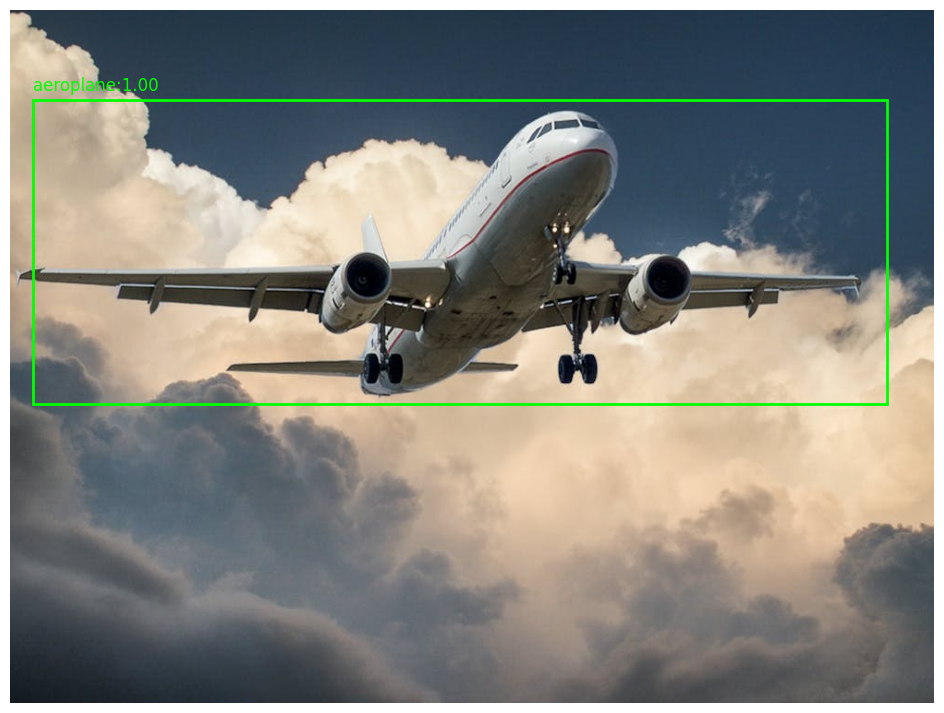


--- GÖREV 2 TAMAMLANDI ---


In [2]:
# ====================================================================
# GÖREV 2 & 3: NESNE TESPİTİ VE TAKİBİ
# ====================================================================
# --- Gerekli Kütüphaneler ve Ayarlar ---
import torch, torchvision, torch.nn as nn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import os, numpy as np, requests, cv2
import matplotlib.pyplot as plt, matplotlib.patches as patches
from torchvision import transforms as T
import xml.etree.ElementTree as ET

# --- Genel Ayarlar ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Kullanılacak Cihaz: {device}")
os.makedirs('/kaggle/working/models', exist_ok=True)
os.makedirs('/kaggle/working/output', exist_ok=True)

# ====================================================================
# GÖREV 2: NESNE TESPİT MODELİ EĞİTİMİ
# ====================================================================

# --- 2.1) Veri Seti Yolu ---
# Lütfen "Add Data" menüsünden PASCAL VOC 2012'yi eklediğinizden emin olun
DATASET_PATH = '/kaggle/input/pascal-voc-2012/VOC2012'

# --- 2.2) Özel Veri Seti Sınıfı: PascalVOCDataset ---
class PascalVOCDataset(Dataset):
    """
    PASCAL VOC 2012 veri setini okumak, filtrelemek ve PyTorch için hazırlamak
    üzere tasarlanmış özel Dataset sınıfı.
    """
    def __init__(self, root_dir, transforms=None):
        self.root_dir, self.transforms = root_dir, transforms
        self.image_dir, self.annotation_dir = os.path.join(root_dir,'JPEGImages'), os.path.join(root_dir,'Annotations')
        self.class_map = {"background":0, "car":1, "bus":2, "train":3, "motorbike":4, "bicycle":5, "aeroplane":6, "boat":7}
        self.class_names = {v: k for k, v in self.class_map.items()}; self.image_files, self.annotation_files = [], []
        for xml_file in sorted(os.listdir(self.annotation_dir)):
            root = ET.parse(os.path.join(self.annotation_dir, xml_file)).getroot()
            if any(member.find('name').text.lower() in self.class_map for member in root.findall('object') if member.find('name').text.lower() != "background"):
                self.image_files.append(root.find('filename').text); self.annotation_files.append(xml_file)
    def __len__(self): return len(self.image_files)
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.image_dir, self.image_files[idx])).convert("RGB")
        root = ET.parse(os.path.join(self.annotation_dir, self.annotation_files[idx])).getroot()
        boxes, labels = [], []
        for member in root.findall('object'):
            class_name = member.find('name').text.lower()
            if class_name in self.class_map and class_name != "background":
                bndbox = member.find('bndbox'); boxes.append([int(bndbox.find(t).text) for t in ['xmin','ymin','xmax','ymax']]); labels.append(self.class_map[class_name])
        target = {"boxes": torch.as_tensor(boxes, dtype=torch.float32), "labels": torch.as_tensor(labels, dtype=torch.int64)}
        if self.transforms: image = self.transforms(image)
        return image, target

# --- 2.3) Veri Yükleyicilerin Hazırlanması ---
def collate_fn(batch): return tuple(zip(*batch))
full_dataset_detection = PascalVOCDataset(root_dir=DATASET_PATH, transforms=T.Compose([T.ToTensor()]))
train_dataset_detection, val_dataset_detection = torch.utils.data.random_split(full_dataset_detection, [int(0.8*len(full_dataset_detection)), len(full_dataset_detection)-int(0.8*len(full_dataset_detection))])
train_loader_detection = DataLoader(train_dataset_detection, batch_size=4, shuffle=True, collate_fn=collate_fn)

# --- 2.4) Model Mimarisi ve Eğitim ---
def get_object_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    model.roi_heads.box_predictor = FastRCNNPredictor(model.roi_heads.box_predictor.cls_score.in_features, num_classes)
    return model

NUM_CLASSES, num_epochs_detection = 8, 5
model_detection = get_object_detection_model(NUM_CLASSES).to(device)
params = [p for p in model_detection.parameters() if p.requires_grad]
optimizer_detection = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

print("\nGörev 2: Nesne Tespiti Modeli Eğitimi Başlatılıyor...")
for epoch in range(num_epochs_detection):
    model_detection.train(); total_loss = 0
    for images, targets in train_loader_detection:
        images=[img.to(device) for img in images]; targets=[{k:v.to(device) for k,v in t.items()} for t in targets]
        loss_dict = model_detection(images, targets); losses = sum(loss for loss in loss_dict.values())
        optimizer_detection.zero_grad(); losses.backward(); optimizer_detection.step(); total_loss += losses.item()
    print(f"Epoch {epoch+1}/{num_epochs_detection}, Ortalama Kayıp: {total_loss/len(train_loader_detection):.4f}")

MODEL_SAVE_PATH = '/kaggle/working/models/pascal_object_detector.pth'
torch.save(model_detection.state_dict(), MODEL_SAVE_PATH)
print(f"\nEğitim Tamamlandı! Model '{MODEL_SAVE_PATH}' olarak kaydedildi.")

# --- 2.5) Çıkarım ve Çoklu Görsel Testi ---
def visualize_detections_inference(image, model, threshold=0.7):
    image_tensor = T.Compose([T.ToTensor()])(image).unsqueeze(0).to(device)
    with torch.no_grad():
        predictions = model(image_tensor)
    fig, ax = plt.subplots(1, figsize=(12, 9)); ax.imshow(image)
    for box, score, label in zip(predictions[0]['boxes'], predictions[0]['scores'], predictions[0]['labels']):
        if score > threshold:
            box = box.cpu().numpy(); rect = patches.Rectangle((box[0],box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='lime', facecolor='none'); ax.add_patch(rect)
            plt.text(box[0], box[1]-10, f'{full_dataset_detection.class_names.get(label.item(), "?")}:{score:.2f}', color='lime', fontsize=12)
    plt.axis('off'); plt.show()

image_urls = {
    "city_traffic.jpg": "https://images.pexels.com/photos/3785424/pexels-photo-3785424.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1",
    "airport.jpg": "https://images.pexels.com/photos/46148/aircraft-jet-landing-cloud-46148.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1",
}
model_detection.eval() # Modeli çıkarım moduna al
for filename, url in image_urls.items():
    try:
        image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
        print(f"\n--- Test Sonucu: {filename} ---")
        visualize_detections_inference(image, model_detection)
    except Exception as e: print(f"{filename} işlenirken bir hata oluştu: {e}")
print("\n--- GÖREV 2 TAMAMLANDI ---")


In [3]:
%%writefile sort.py
import numpy as np
from filterpy.kalman import KalmanFilter
from scipy.optimize import linear_sum_assignment

def iou_batch(bb_test, bb_gt):
    bb_gt = np.expand_dims(bb_gt, 0)
    bb_test = np.expand_dims(bb_test, 1)
    xx1 = np.maximum(bb_test[..., 0], bb_gt[..., 0])
    yy1 = np.maximum(bb_test[..., 1], bb_gt[..., 1])
    xx2 = np.minimum(bb_test[..., 2], bb_gt[..., 2])
    yy2 = np.minimum(bb_test[..., 3], bb_gt[..., 3])
    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)
    wh = w * h
    union = ((bb_test[..., 2] - bb_test[..., 0]) * (bb_test[..., 3] - bb_test[..., 1])
           + (bb_gt[..., 2] - bb_gt[..., 0]) * (bb_gt[..., 3] - bb_gt[..., 1]) - wh)
    iou = wh / union
    return iou

class KalmanBoxTracker(object):
    count = 0
    def __init__(self, bbox):
        self.kf = KalmanFilter(dim_x=7, dim_z=4)
        self.kf.F = np.array([[1,0,0,0,1,0,0],[0,1,0,0,0,1,0],[0,0,1,0,0,0,1],[0,0,0,1,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]])
        self.kf.H = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0]])
        self.kf.R[2:,2:] *= 10.
        self.kf.P[4:,4:] *= 1000.
        self.kf.P *= 10.
        self.kf.Q[-1,-1] *= 0.01
        self.kf.Q[4:,4:] *= 0.01
        self.kf.x[:4] = self.convert_bbox_to_z(bbox)
        self.time_since_update = 0
        self.id = KalmanBoxTracker.count
        KalmanBoxTracker.count += 1
        self.history = []
        self.hits = 0
        self.hit_streak = 0
        self.age = 0

    def convert_bbox_to_z(self, bbox):
        w = bbox[2] - bbox[0]
        h = bbox[3] - bbox[1]
        x = bbox[0] + w/2.
        y = bbox[1] + h/2.
        s = w * h
        r = w / float(h)
        return np.array([x, y, s, r]).reshape((4, 1))

    def convert_x_to_bbox(self, x, score=None):
        w = np.sqrt(x[2] * x[3])
        h = x[2] / np.sqrt(x[2] * x[3])
        bbox = [x[0]-w/2., x[1]-h/2., x[0]+w/2., x[1]+h/2.]
        # --- DÜZELTİLEN KISIM ---
        if score is not None:
            bbox.append(score)
        return np.array(bbox).reshape((1, -1))

    def update(self, bbox):
        self.time_since_update = 0
        self.history = []
        self.hits += 1
        self.hit_streak += 1
        self.kf.update(self.convert_bbox_to_z(bbox))

    def predict(self):
        if((self.kf.x[6]+self.kf.x[2])<=0):
            self.kf.x[6] *= 0.0
        self.kf.predict()
        self.age += 1
        if(self.time_since_update>0):
            self.hit_streak = 0
        self.time_since_update += 1
        self.history.append(self.convert_x_to_bbox(self.kf.x))
        return self.history[-1]

    def get_state(self):
        return self.convert_x_to_bbox(self.kf.x)

class Sort(object):
    def __init__(self, max_age=5, min_hits=3, iou_threshold=0.3):
        self.max_age = max_age
        self.min_hits = min_hits
        self.iou_threshold = iou_threshold
        self.trackers = []
        self.frame_count = 0

    def update(self, dets=np.empty((0, 5))):
        self.frame_count += 1
        trks = np.zeros((len(self.trackers), 5))
        to_del = []
        ret = []
        for t, trk in enumerate(trks):
            pos = self.trackers[t].predict()[0]
            trk[:] = [pos[0], pos[1], pos[2], pos[3], 0]
            if np.any(np.isnan(pos)):
                to_del.append(t)
        trks = np.ma.compress_rows(np.ma.masked_invalid(trks))
        for t in reversed(to_del):
            self.trackers.pop(t)
        
        matched, unmatched_dets, unmatched_trks = self.associate_detections_to_trackers(dets, trks, self.iou_threshold)

        for m in matched:
            self.trackers[m[1]].update(dets[m[0], :])

        for i in unmatched_dets:
            trk = KalmanBoxTracker(dets[i,:])
            self.trackers.append(trk)
        
        i = len(self.trackers)
        for trk in reversed(self.trackers):
            d = trk.get_state()[0]
            if (trk.time_since_update < 1) and (trk.hit_streak >= self.min_hits or self.frame_count <= self.min_hits):
                ret.append(np.concatenate((d,[trk.id+1])).reshape(1,-1))
            i -= 1
            if(trk.time_since_update > self.max_age):
                self.trackers.pop(i)
        
        if(len(ret)>0):
            return np.concatenate(ret)
        return np.empty((0,5))

    def associate_detections_to_trackers(self, detections, trackers, iou_threshold):
        if not np.any(trackers):
            return np.empty((0,2),dtype=int), np.arange(len(detections)), np.empty((0,5),dtype=int)
        
        iou_matrix = iou_batch(detections[:,:4], trackers)

        if min(iou_matrix.shape) > 0:
            a = (iou_matrix > iou_threshold).astype(np.int32)
            if a.sum(1).max() == 1 and a.sum(0).max() == 1:
                matched_indices = np.stack(np.where(a), axis=1)
            else:
                row_ind, col_ind = linear_sum_assignment(-iou_matrix)
                matched_indices = np.array(list(zip(row_ind, col_ind)))
        else:
            matched_indices = np.empty(shape=(0,2))

        unmatched_detections = [d for d, det in enumerate(detections) if d not in matched_indices[:,0]]
        unmatched_trackers = [t for t, trk in enumerate(trackers) if t not in matched_indices[:,1]]
        
        matches = []
        for m in matched_indices:
            if(iou_matrix[m[0], m[1]] < iou_threshold):
                unmatched_detections.append(m[0])
                unmatched_trackers.append(m[1])
            else:
                matches.append(m.reshape(1,2))
        
        if not matches:
            matches = np.empty((0,2),dtype=int)
        else:
            matches = np.concatenate(matches,axis=0)

        return matches, np.array(unmatched_detections), np.array(unmatched_trackers)

Writing sort.py


In [4]:
# ====================================================================
# GÖREV 3: VİDEO İLE NESNE TAKİBİ
# ====================================================================

# --- 1) Gerekli Kütüphaneler ---
# Not: Bu hücrenin çalışması için bir önceki hücrede `%%writefile sort.py` 
# komutuyla `sort.py` dosyasının oluşturulduğu varsayılmaktadır.
from sort import Sort 
import cv2
from PIL import Image
import torch
from torchvision import transforms as T
import numpy as np
import os

# --- 2) Yapılandırma (Configuration) ---
VIDEO_PATH = '/kaggle/input/street-traffic/Drone Street Traffic New York City.mp4'
OUTPUT_PATH = '/kaggle/working/output/street.mp4'
CONFIDENCE_THRESHOLD = 0.6 # Tespitler için minimum güven skoru
CLASS_NAMES_MAP = full_dataset_detection.class_names # Görev 2'de oluşturulan veri setinden sınıf isimleri

# --- 3) Modelin ve Tracker'ın Hazırlanması ---
# Görev 2'de eğitilen ve hafızada bulunan modeli kullanıyoruz
tracking_model = model_detection
# Modeli çıkarım (inference) moduna alarak tutarlı sonuçlar sağlıyoruz
tracking_model.eval()

# SORT takipçisi; max_age=30, kısa süreli tespit kayıplarına karşı tutarlılığı artırır.
tracker = Sort(max_age=30, min_hits=3, iou_threshold=0.3)
# Her ID için tutarlı renkler üretmek amacıyla seed sabitlenir
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(500, 3), dtype="uint8")

# --- 4) Video Okuyucu ve Yazıcının Hazırlanması ---
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    print(f"Hata: Video dosyası açılamadı: {VIDEO_PATH}")
else:
    # Video özelliklerini al
    frame_width, frame_height, fps = int(cap.get(3)), int(cap.get(4)), int(cap.get(5))
    # Çıktı videosu için yazıcıyı oluştur
    out = cv2.VideoWriter(OUTPUT_PATH, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    print("\nGörev 3: Video işleniyor...")
    
    # --- 5) Ana Video İşleme Döngüsü ---
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break # Video bittiyse döngüyü sonlandır

        # Kareyi modele uygun formata getir (BGR -> RGB -> Tensor)
        pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        image_tensor = T.Compose([T.ToTensor()])(pil_image).unsqueeze(0).to(device)

        # Nesne tespiti yap
        with torch.no_grad():
            predictions = tracking_model(image_tensor)
            
        # Tespitleri SORT'un beklediği [x1, y1, x2, y2, score] formatına çevir
        detections = []
        for i in range(len(predictions[0]['boxes'])):
            score, label_id = predictions[0]['scores'][i].item(), predictions[0]['labels'][i].item()
            if score > CONFIDENCE_THRESHOLD and label_id in CLASS_NAMES_MAP:
                detections.append([*(predictions[0]['boxes'][i].cpu().numpy()), score])
                
        # Tracker'ı güncelle ve takip edilen nesnelerin son konumlarını al
        tracked_objects = tracker.update(np.array(detections) if detections else np.empty((0, 5)))

        # Takip edilen nesneleri kare üzerine çiz
        for obj in tracked_objects:
            x1, y1, x2, y2, track_id = obj.astype(int)
            color = [int(c) for c in COLORS[track_id % len(COLORS)]]
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, f'ID:{track_id}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        
        # İşlenmiş kareyi video dosyasına yaz
        out.write(frame)

    # --- 6) Kaynakları Serbest Bırak ---
    cap.release()
    out.release()
    print(f"İşlem tamamlandı! Sonuç videosu şuraya kaydedildi: {OUTPUT_PATH}")


Görev 3: Video işleniyor...
İşlem tamamlandı! Sonuç videosu şuraya kaydedildi: /kaggle/working/output/street.mp4
